# <font color=darkcyan> First implementation of a few MCMC algorithms</font>
#### <font color=darkorange>Metropolis-Hastings and MALA </font>

In [ ]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [ ]:
"""""""""""""""""
Required packages
"""""""""""""""""
import seaborn as sns
import autograd.numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
# package which differentiates standard Python and Numpy code
from autograd import grad
# to get progress bars
from tqdm import tqdm

In a Bayesian setting, a parameter $x$ is embedded with a prior distribution $\pi$ and the observations are given by a probabilistic model:

$$
Y\sim \ell(\cdot|x)\,.
$$


The inference is then based on the posterior distribution:
$$
\pi(x|Y) = \frac{\pi(x)\ell(Y|x)}{\int\pi(u)\ell(Y|u)\mathrm{d} u}\,.
$$


In most cases the normalizing constant is not tractable:
$$
\pi(x|Y) \propto \pi(x)\ell(Y|x)\,.
$$

``Markov chain Monte Carlo (MCMC) algorithms`` provide solutions to sample from posterior distributions. ``Hamiltonian Monte Carlo (HMC)`` is a MCMC algorithm that uses gradient information to scale better to higher dimensions. It is used by software like [PyMC3](https://pymc.io/) and [Stan](https://mc-stan.org/). 

Some references on MCMC...
- **Douc R., Moulines E. and Stoffer D.**, Nonlinear time series: theory, methods and applications with R example, 2014, Chapman \& Hall.
- **Michael Betancourt, [A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)** A thorough, readable reference that is the main source here

In the following cells, we drop $Y$ from the notations and consider a target distribution written $\pi(x)$.

### <font color=darkorange> A few simple models </font>

In the following, the target density is written $\pi$. We define below two examples of target densities $\pi$ which will be used to assess the efficiency of the proposed MCMC algorithm.

<font color=darkred> Write a function returning the opposite of the log probability density of </font>
    
<font color=darkred>    i) a Gaussian random variable with mean mu and covariance matrix sigma; </font>
    
<font color=darkred>    ii) a mixture of probability density functions. </font>

In [1]:
def multi_gauss(mu, sigma):
    """
    Inputs
    ----------
    mu: mean of the Gaussian distribution
    sigma: covariance matrix of the Gaussian distribution
    
    Outputs
    -------
    logp: opposite of the loglikelihood
    """

    def logp(x):
        k   = mu.shape[0]
        cst       = k * np.log(2 * np.pi)
        det       = np.log(np.linalg.det(sigma))
        quad_term = np.dot(np.dot((x - mu).T, np.linalg.inv(sigma)), x - mu)
        return (cst +  det + quad_term) * 0.5
    
    return logp

def mixture(log_prob, weights):
    """
    Inputs
    ----------
    log_prob: opposite of the likelihood of each term
    weights: weights of the components of the mixture
    
    Outputs
    -------
    logp: opposite of the loglikelihood of the mixture
    """
    
    def logp(x):
        likelihood = 0
        for j in range(np.size(weights)):
            log_marginal = -log_prob[j](x)
            likelihood   = likelihood + weights[j]*np.exp(log_marginal)
        
        return -np.log(likelihood)

    return logp

In [2]:
grid_lim = 6
# grid on which the target pdf is displayed
grid_plot = (-grid_lim, grid_lim, -grid_lim, grid_lim)
# coordinates chosen on this grid
nb_points = 100

xplot = np.linspace(-grid_lim, grid_lim, nb_points)
yplot = np.linspace(-grid_lim, grid_lim, nb_points)
Xplot, Yplot = np.meshgrid(xplot, yplot)

NameError: name 'np' is not defined

<font color=darkred> Display a target density defined as a mixture of 2-dimensional Gaussian distributions. </font>

In [5]:
mu1 = 2*np.ones(2)
cov1 = np.array([[1., 0.5],
                [0.5, 1.]])
mu2 = -mu1
cov2 = np.array([[1., -0.1],
                [-0.1, 1.]])

mu3 = np.array([-1.5, 2.2])
cov3 = 0.8 * np.eye(2)

mu4 = np.array([2.5, -4.2])
cov4 = 0.5 * np.eye(2)

log_p = mixture([multi_gauss(mu1, cov1), multi_gauss(mu2, cov2), multi_gauss(mu3, cov3), multi_gauss(mu4, cov4)], [0.25, 0.35, 0.3,0.1])

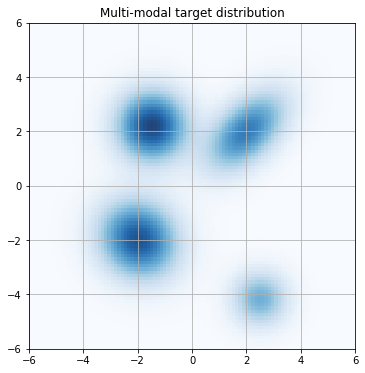

In [6]:
fig = plt.figure(figsize=(6,6))
plt.title('Multi-modal target distribution')
Zplot = np.copy(Xplot)
for i in range(nb_points):
    for j in range(nb_points):
        Zplot[i][j] = np.exp(-log_p(np.array((Xplot[i][j], Yplot[i][j]))))
plt.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
plt.grid(True)

## <font color=darkcyan> Metropolis-Hastings algorithm </font>

``Objective target density:`` $\pi(x)$.

``Instrumental transition density:`` $q(x,y)$.

At each iteration $k\geqslant 0$, generate $Z_{k+1} \sim q(X_k,\cdot)$.

Set $X_{k+1} = Z_{k+1}$ with probability $\alpha(X_k,Z_{k+1})$ and  $X_{k+1} = X_k$ with probability $1-\alpha(X_k,Z_{k+1})$, where 

$$
\alpha(x,y) = 1\wedge\frac{\pi(y)}{\pi(x)}\frac{q(y,x)}{q(x,y)}\,.
$$

<font color=darkred> Write a function which returns samples from Metropolis-Hastings algorithm with Gaussian proposal density.</font>

In [7]:
def HM_monte_carlo(n_samples, log_prob, initial_state, step_size = 0.1):
    """
    Inputs
    ----------
    n_samples: number of samples to return
    log_prob: opposite of the loglikelihood to sample from
    initial_state: initial sample
    step_size: standard deviation of the proposed moves
    
    Outputs
    -------
    samples: samples from the MCMC algorithm
    accepted: array of 0 and 1 to display which proposed moves have been accepted
    """
    initial_state = np.array(initial_state)
    
    samples  = [initial_state]
    accepted = []

    size = (n_samples,) + initial_state.shape[:1]
    
    # random variable to sample proposed moves
    epsilon = st.norm(0, 1).rvs(size)
    
    for noise in tqdm(epsilon):
        
        q_new = samples[-1] + step_size*noise
       
        # acceptance rate
        old_log_p = log_prob(samples[-1]) 
        new_log_p = log_prob(q_new) 
        
        if np.log(np.random.rand()) < old_log_p - new_log_p:
            samples.append(q_new)
            accepted.append(True)
        else:
            samples.append(np.copy(samples[-1]))
            accepted.append(False)

    return (np.array(samples[1:]),np.array(accepted),)

## <font color=darkcyan> Metropolis Adjusted Langevin algorithm (MALA) </font>

``Objective target density:`` $\pi(x)$.

At each iteration $k\geqslant 0$, generate $Z_{k+1} \sim X_k + \frac{\sigma^2}{2}\nabla\log\pi(X_k|Y) + \sigma \varepsilon_{k+1}$.

Set $X_{k+1} = Z_{k+1}$ with probability $\alpha(X_k,Z_{k+1})$ and  $X_{k+1} = X_k$ with probability $1-\alpha(X_k,Z_{k+1})$, where 

$$
\alpha(x,y) = 1\wedge\frac{\pi(y)}{\pi(x)}\frac{q(y,x)}{q(x,y)}\,,
$$

where $q(x,y)$ is the Gaussian pdf with mean $x + \frac{\sigma^2}{2}\nabla\log\pi(x)$ and variance $\sigma^2 I_d$.

<font color=darkred> Write a function which returns samples from MALA algorithm.</font>

In [8]:
def MALA_monte_carlo(n_samples, log_prob, initial_state, step_size = 0.1):
    """
    Inputs
    ----------
    n_samples: number of samples to return
    log_prob: opposite of the loglikelihood to sample from
    initial_state: initial sample
    step_size: standard deviation of the proposed moves
    
    Outputs
    -------
    samples: samples from the MCMC algorithm
    accepted: array of 0 and 1 to display which proposed moves have been accepted
    """
    initial_state = np.array(initial_state)

    gradV = grad(log_prob)

    samples  = [initial_state]
    accepted = []

    size = (n_samples,) + initial_state.shape[:1]
    
    # random variable to sample proposed moves
    epsilon = st.norm(0, 1).rvs(size)
    
    for noise in tqdm(epsilon):
        
        grad_new = gradV(samples[-1])
        mean_new = samples[-1] - 0.5*step_size*step_size*grad_new
        
        q_new    = mean_new + step_size*noise
       
        grad_y   = gradV(q_new)
        mean_y   = q_new - 0.5*step_size*step_size*grad_y
        
        # acceptance rate
        old_log_p = log_prob(samples[-1]) + 0.5*np.dot(q_new-mean_new,q_new-mean_new)/(step_size**2)
        new_log_p = log_prob(q_new) + 0.5*np.dot(samples[-1]-mean_y,samples[-1]-mean_y)/(step_size**2)
        
        if np.log(np.random.rand()) < old_log_p - new_log_p:
            samples.append(q_new)
            accepted.append(True)
        else:
            samples.append(np.copy(samples[-1]))
            accepted.append(False)

    return (np.array(samples[1:]),np.array(accepted),)

### <font color=darkorange> A few samples </font>

In [10]:
n_samples = 20000

<font color=darkred> Run both algorithms to produce Markov chains with length n_samples.</font>

In [11]:
samples_HM, accepted_HM = HM_monte_carlo(n_samples, log_p, np.random.randn(2), 0.1)

100%|██████████| 20000/20000 [00:06<00:00, 3139.25it/s]


In [12]:
samples_Mala, accepted_Mala = MALA_monte_carlo(n_samples, log_p, np.random.randn(2), 0.1)

100%|██████████| 20000/20000 [01:15<00:00, 266.38it/s]


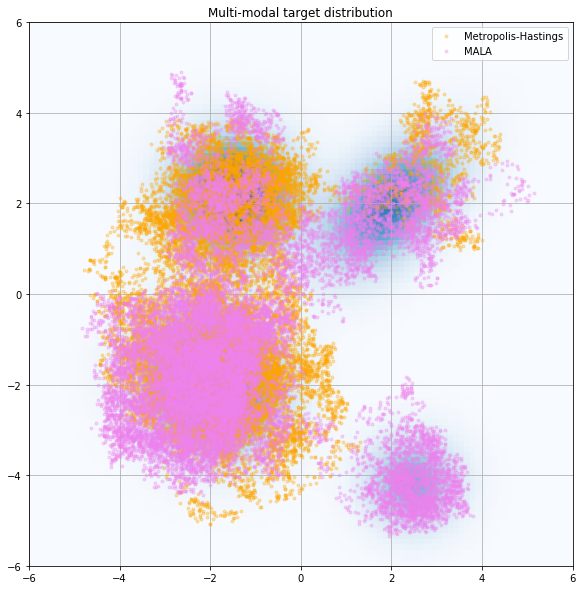

In [14]:
fig = plt.figure(figsize=(10,10))
plt.title('Multi-modal target distribution')
Zplot = np.copy(Xplot)
for i in range(nb_points):
    for j in range(nb_points):
        Zplot[i][j] = np.exp(-log_p(np.array((Xplot[i][j], Yplot[i][j]))))
plt.imshow(Zplot, alpha = 0.9, extent = grid_plot, cmap='Blues', origin='top')
plt.plot(samples_HM[:,0], samples_HM[:,1], '.', color='orange', alpha = 0.3, label = 'Metropolis-Hastings')
plt.plot(samples_Mala[:,0], samples_Mala[:,1], '.', color='violet', alpha = 0.3, label = 'MALA')
plt.grid(True)
plt.legend();

### <font color=darkorange> Parameters tuning </font>

<font color=darkred>Display the mean acceptance rate for both algorithms</font>

<font color=darkred>Provide an estimate of the mean of the target distribution for both algorithms</font>

<font color=darkred>Analyze the influence of the step-size for both algorithms (in particular on the mean acceptance rates)</font>

<font color=darkred>Provide a comparison between the empirical distributions from the target and for both algorithms</font>